In [8]:
import sys, os, ndreg, skimage
import matplotlib.pyplot as plt
from matplotlib import cm
from ndreg import preprocessor, registerer
import SimpleITK as sitk
import numpy as np
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
import missing_data_sim as mdmask

In [9]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

# Ingest methods

In [10]:
def upload_to_boss(rmt, data, channel_resource, resolution=0):
    Z_LOC = 0
    size = data.shape
    for i in range(0, data.shape[Z_LOC], 16):
        last_z = i+16
        if last_z > data.shape[Z_LOC]:
            last_z = data.shape[Z_LOC]
        print(resolution, [0, size[2]], [0, size[1]], [i, last_z])
        rmt.create_cutout(channel_resource, resolution, [0, size[2]], [0, size[1]], [i, last_z], np.asarray(data[i:last_z,:,:], order='C'))
        
def get_channel_resource(rmt, chan_name, coll_name, exp_name, type='image', base_resolution=0, sources=[], datatype='uint16', new_channel=True):
    channel_resource = ChannelResource(chan_name, coll_name, exp_name, type=type,
                             base_resolution=base_resolution, sources=sources, datatype=datatype)
    if new_channel:
        new_rsc = rmt.create_project(channel_resource)
        return new_rsc

    return channel_resource

## Visualization methods

In [11]:
def get_img_grid(img, cmap='Greys'):
    numSlices = 3
    size = img.GetSize()
    ret = []
    for i in range(img.GetDimension()):
        start = size[2 - i] / (numSlices + 1)
        sliceList = np.linspace(start, size[2 - i] - start, numSlices)
        sliceSize = list(size)
        sliceSize[2 - i] = 0

        for (j, slice) in enumerate(sliceList):
            sliceIndex = [0] * img.GetDimension()
            sliceIndex[2 - i] = int(slice)
            sliceImg = sitk.Extract(img, sliceSize, sliceIndex)
            sliceArray = sitk.GetArrayFromImage(sliceImg)
            ret.append(sliceArray)
    return ret

In [12]:
# def register_affine(atlas, img, learning_rate=1e-2, iters=200, min_step=1e-10, shrink_factors=[1],
#      sigmas=[.150], use_mi=False, grad_tol=1e-6, verbose=False):
#     registration_method = sitk.ImageRegistrationMethod()

#     if use_mi: registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=128)
#     else: registration_method.SetMetricAsMeanSquares()

#     registration_method.SetInterpolator(sitk.sitkBSpline)

#     registration_method.SetOptimizerAsRegularStepGradientDescent(learningRate=learning_rate,
#                                                           minStep=min_step,
#                                                           gradientMagnitudeTolerance=grad_tol,
#                                                           numberOfIterations=iters)
#     registration_method.SetOptimizerScalesFromPhysicalShift()

#     registration_method.SetShrinkFactorsPerLevel(shrinkFactors=shrink_factors)
#     registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=sigmas)
#     registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

#     initial_transform = sitk.AffineTransform(atlas.GetDimension())
#     length = np.array(atlas.GetSize())*np.array(atlas.GetSpacing())
#     initial_transform.SetCenter(length/2.0)

#     registration_method.SetInitialTransform(initial_transform)
    
#     values = []

#     registration_method.AddCommand(sitk.sitkIterationEvent, lambda: values.append(registration_method.GetMetricValue()))

#     final_transform = registration_method.Execute(sitk.Cast(img, sitk.sitkFloat32),
#                                                sitk.Cast(atlas, sitk.sitkFloat32))
#     return final_transform, values

In [13]:
def register_affine(atlas, img, learning_rate=1e-2, iters=200, min_step=1e-10, shrink_factors=[1],
            sigmas=[.150], ref_mask=None, use_mi=False, grad_tol=1e-6, verbose=False):
    registration_method = sitk.ImageRegistrationMethod()

    if use_mi: registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=128)
    else: registration_method.SetMetricAsMeanSquares()

    registration_method.SetInterpolator(sitk.sitkBSpline)

    # Optimizer settings.
    registration_method.SetOptimizerAsRegularStepGradientDescent(learningRate=learning_rate,
                                                                 minStep=min_step,
                                                                 gradientMagnitudeTolerance=grad_tol,
                                                                 numberOfIterations=iters)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=shrink_factors)
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=sigmas)
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
    
    # set the mask
    if ref_mask: registration_method.SetMetricFixedMask(ref_mask)

    # initial transform
    initial_transform = sitk.AffineTransform(atlas.GetDimension())
    length = np.array(atlas.GetSize())*np.array(atlas.GetSpacing())
    initial_transform.SetCenter(length/2.0)

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform)

    # Connect all of the observers so that we can perform plotting during registration.
#     if verbose:
#         registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
#         registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
#         registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations)
#         registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

    final_transform = registration_method.Execute(sitk.Cast(img, sitk.sitkFloat32),
                                                  sitk.Cast(atlas, sitk.sitkFloat32))
    return final_transform

In [14]:
def register_lddmm(affine_img, target_img, alpha_list=0.05, scale_list=[0.0625, 0.125, 0.25, 0.5, 1.0], epsilon_list=1e-4, min_epsilon_list=1e-10, sigma=0.1, use_mi=False, iterations=200, inMask=None, refMask=None, verbose=True, out_dir=''):
    if sigma == None:
        sigma = (0.1/target_img.GetNumberOfPixels())

    (field, invField) = ndreg.imgMetamorphosisComposite(affine_img, target_img,
                                                        alphaList=alpha_list,
                                                        scaleList=scale_list,
                                                        epsilonList=epsilon_list,
                                                        minEpsilonList=min_epsilon_list,
                                                        sigma=sigma,
                                                        useMI=use_mi,
                                                        inMask=inMask,
                                                        refMask=refMask,
                                                        iterations=iterations,
                                                        verbose=verbose,
                                                        outDirPath=out_dir)
#     affineField = ndreg.affineToField(affine, field.GetSize(), field.GetSpacing())
#     fieldComposite = ndreg.fieldApplyField(field, affineField)

#     invAffineField = ndreg.affineToField(ndreg.affineInverse(affine), invField.GetSize(),
#                                          invField.GetSpacing())
#     invFieldComposite = ndreg.fieldApplyField(invAffineField, invField)

    source_lddmm = ndreg.imgApplyField(affine_img, field,
                                            size=target_img.GetSize(),
                                            spacing=target_img.GetSpacing())
    return source_lddmm, field, invField

# Setup Data

In [15]:
resolution = 50

In [16]:
rmt = BossRemote(cfg_file_or_dict='./intern.cfg')
atlas = ndreg.download_ara(rmt, resolution)

In [17]:
atlas_mask = preprocessor.create_mask(atlas, use_triangle=True)

In [18]:
img = sitk.Image(atlas)
img_mask = preprocessor.create_mask(img, use_triangle=True)
width, height, depth = atlas.GetSize()

In [19]:
annotations = ndreg.download_ara(rmt, resolution, type='annotation')

## Create the Missing data masks

In [20]:
# Generates a random half space in the image space
rand_halfspace_array = mdmask.gen_random_halfspace(depth, height, width)
# Mask that cuts the image space exactly in half
hemisphere_array = mdmask.gen_hemisphere_mask(depth, height, width)
# Mask of just the olfactory bulb
olf_bulb_layers = [507, 212, 220, 228, 236, 244, 151, 188, 196, 204]
olf_bulb_array = mdmask.gen_label_mask(annotations, atlas_mask, olf_bulb_layers)


In [21]:
rand_halfspace_mask = mdmask.convert_to_image(rand_halfspace_array.astype('uint16'))
hemisphere_mask = mdmask.convert_to_image(hemisphere_array.astype('uint16'))
olf_bulb_mask = mdmask.convert_to_image(olf_bulb_array.astype('uint16'))


In [22]:
rand_halfspace_mask.CopyInformation(img)
hemisphere_mask.CopyInformation(img)
olf_bulb_mask.CopyInformation(img)
# DAFUQ when a method doesn't do what it says

In [23]:
atlas_rh = mdmask.mask_img(img, rand_halfspace_mask)
atlas_hemi = mdmask.mask_img(img, hemisphere_mask)
atlas_olf = mdmask.mask_img(img, olf_bulb_mask)

In [24]:
rh_grid = get_img_grid(atlas_rh)
hemi_grid = get_img_grid(atlas_hemi)
olf_grid = get_img_grid(atlas_olf)
orig_grid = get_img_grid(atlas)

In [25]:
grids = [orig_grid,rh_grid, hemi_grid, olf_grid]
grid_titles = ['Orig', 'Random Affine', 'Half Hemi', 'Olf bulb']
row_len = len(grids[0])
col_len = len(grids)

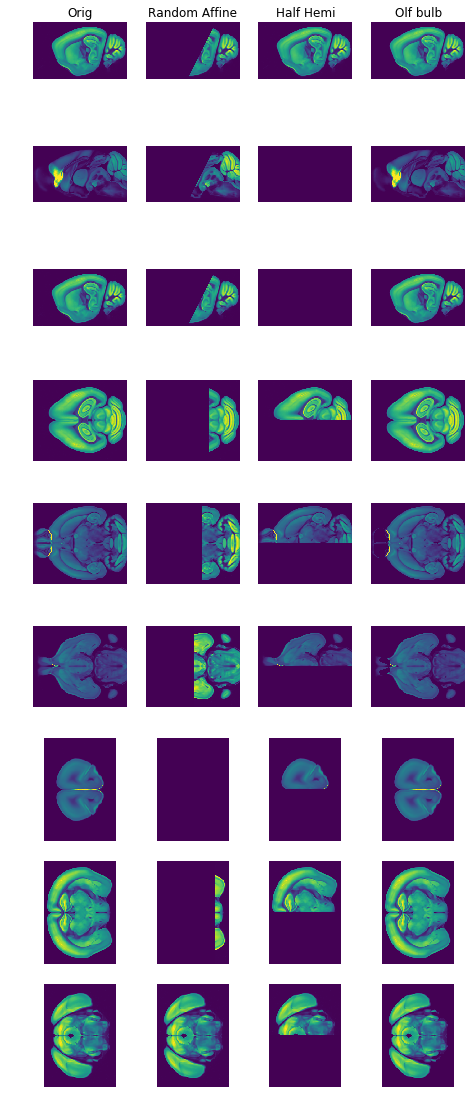

In [26]:
import matplotlib.gridspec as gridspec
plt.clf()
fig = plt.figure(figsize=(40,20))
gs1 = gridspec.GridSpec(
    nrows=row_len, 
    ncols=col_len, 
    left=0.1,
    right=0.25,
)
for i,grid in enumerate(grids):
    for k in range(row_len):
        ax = plt.subplot(gs1[(i+1)+(col_len*k)-1])
        plt.axis('off')
        ax.set_aspect('equal')
        plt.imshow(grid[k])
        if not k:
            ax.set_title(grid_titles[i])
plt.savefig("masked_atlases.png")

# Registration step by step

In [27]:
AFFINE_RESULTS = {}

## Set source and target images

In [28]:
# Target IS img
# Source IS atlas

img,atlas,mask = None,None,None
experiment_type = 1
if experiment_type == 1:
    # Experiment 1
    # Registering whole brain atlas to half atlas w/o mask
    atlas = ndreg.download_ara(rmt, resolution)
    img = sitk.Image(atlas_hemi)
    mask = None
elif experiment_type == 2:
    # Experiment 2
    # Registering whole brain atlas to half atlas with mask
    atlas = ndreg.download_ara(rmt, resolution)
    img = sitk.Image(atlas_hemi)
    mask = hemisphere_mask
elif experiment_type == 3:
    # Experiment 3
    img = ndreg.download_image(rmt, 'ailey-dev', 'Insula_Atenolol-1_171204_new', 'Ch0', res=3)
    atlas = sitk.Image(atlas_hemi)
    mask = None
elif experiment_type == 4:
    # Experiment 4
    img = ndreg.download_image(rmt, 'ailey-dev', 'Insula_Atenolol-1_171204_new', 'Ch0', res=3)
    width, height, depth = img.GetSize()
    hemisphere_array = mdmask.gen_hemisphere_mask(depth, height, width)
    hemisphere_mask = mdmask.convert_to_image(hemisphere_array.astype('uint16'))
    hemisphere_mask.CopyInformation(img)
    img = mdmask.mask_img(img, hemisphere_mask)
    atlas = sitk.Image(atlas_hemi)
    img.SetSpacing((0.05,0.05,0.05))
    mask = hemisphere_mask

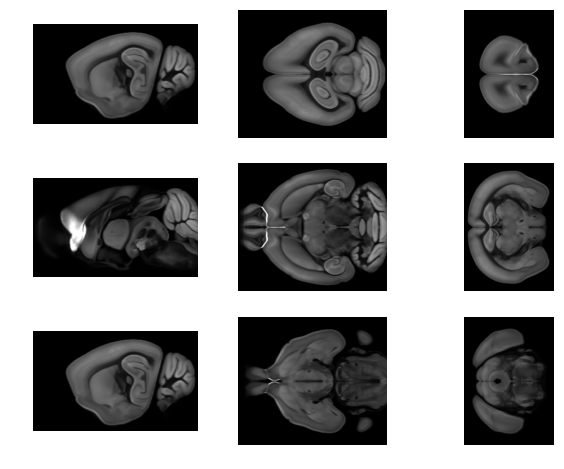

In [29]:
ndreg.imgShow(img)

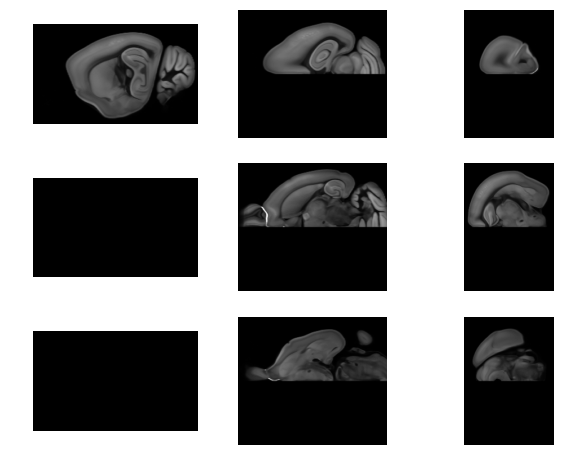

In [30]:
ndreg.imgShow(atlas)

## Create masks

In [31]:
mask_sitk = preprocessor.create_mask(img, use_triangle=True)

### Skipping resampling and bias correction... Doing more harm than good

In [32]:
atlas_ds = sitk.Normalize(atlas)
img_bc_ds = sitk.Normalize(img)

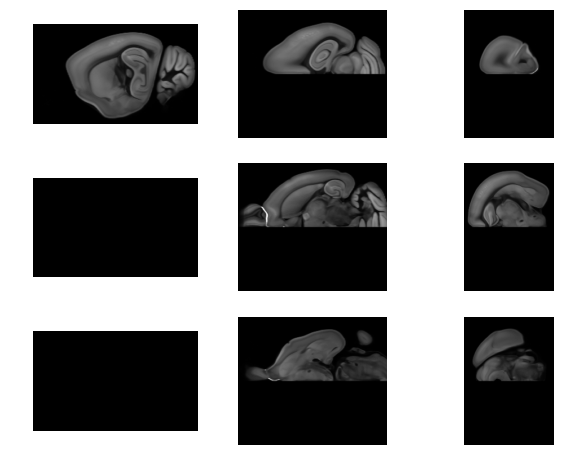

In [33]:
ndreg.imgShow(atlas_ds)

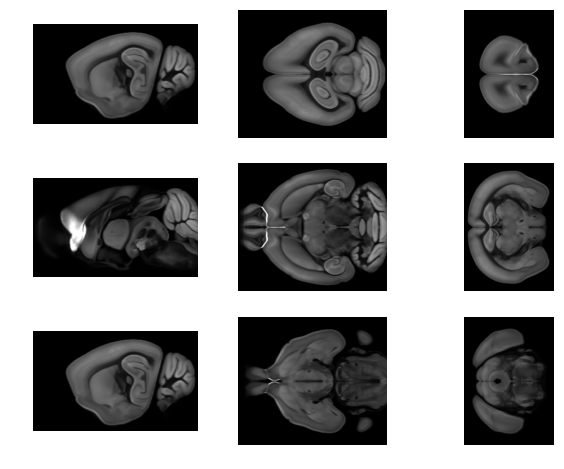

In [34]:
ndreg.imgShow(img_bc_ds)

# Registration part

In [35]:
final_transform = register_affine(atlas_ds, 
                                img_bc_ds,
                                ref_mask=mask,
                                learning_rate=1e-1,
                                grad_tol=4e-6,
                                use_mi=False,
                                iters=25,
                                shrink_factors=[4,2,1],
                                sigmas=[0.6, 0.3, 0.150],
                                verbose=True)

In [36]:
out_atlas = registerer.resample(atlas_ds, final_transform, atlas_ds)
out_target = registerer.resample(img_bc_ds, final_transform.GetInverse(), img_bc_ds)

# out_target = sitk.Resample(img_bc_ds, img_bc_ds, final_transform,
#                          sitk.sitkCosineWindowedSinc, 0.0)
                                 

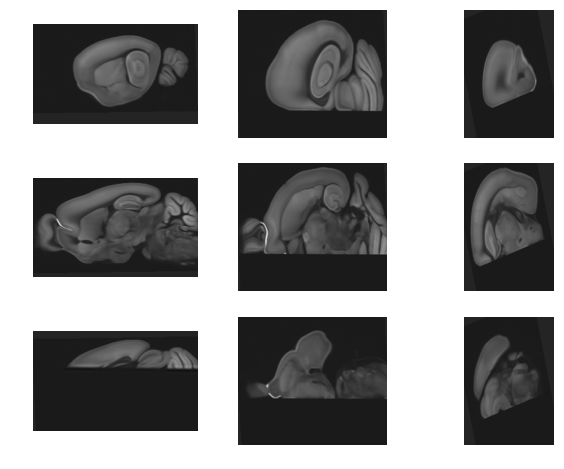

In [37]:
ndreg.imgShow(out_atlas)

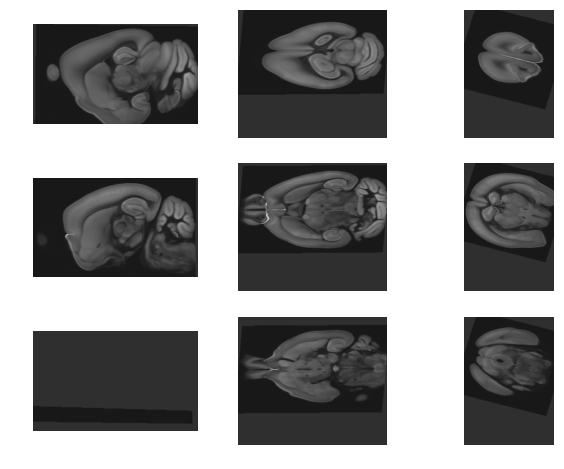

In [38]:
ndreg.imgShow(out_target)

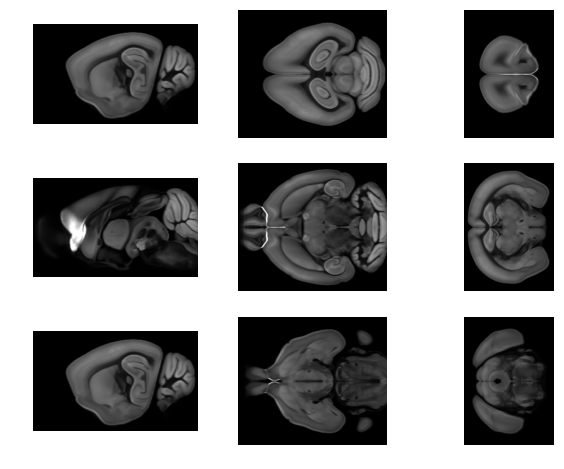

In [39]:
ndreg.imgShow(img_bc_ds)

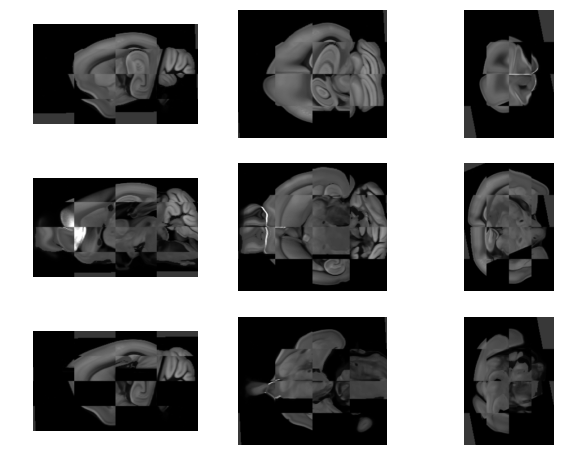

In [40]:
ndreg.imgShow(ndreg.imgChecker(out_atlas, img_bc_ds))

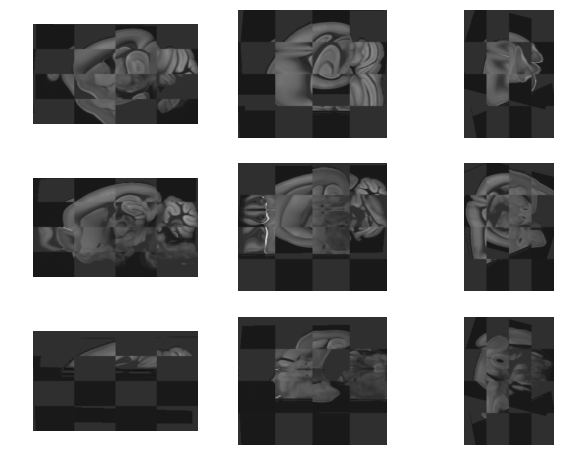

In [41]:
ndreg.imgShow(ndreg.imgChecker(out_atlas, out_target))

In [42]:
atlas_kernel = [5,5,5]

In [43]:
out_atlas_whitened = preprocessor.whiten(out_atlas, radius=atlas_kernel)
img_bc_ds_whitened = preprocessor.whiten(img_bc_ds, radius=atlas_kernel)

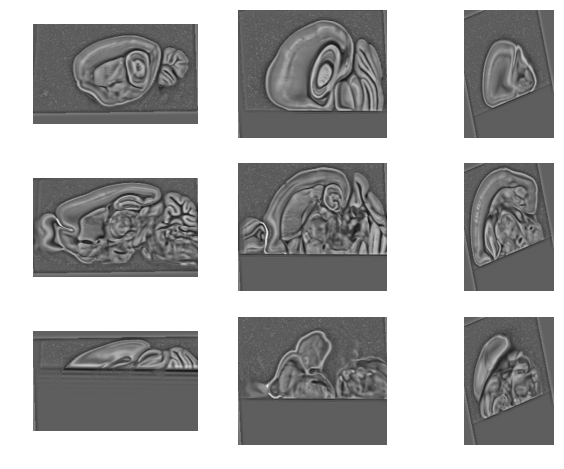

In [44]:
ndreg.imgShow(out_atlas_whitened)

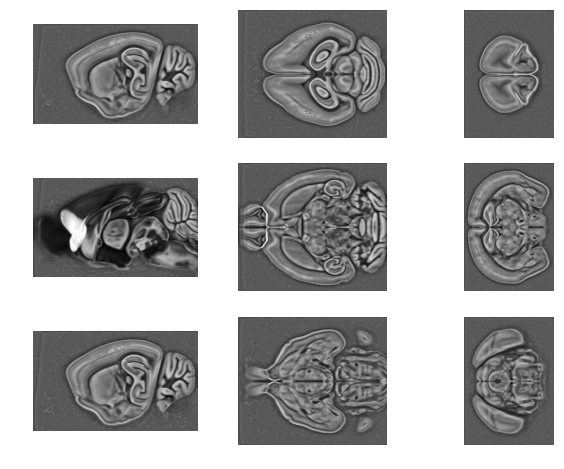

In [45]:
ndreg.imgShow(img_bc_ds_whitened)

## lddmm

In [46]:
assert out_atlas_whitened.GetSpacing() == img_bc_ds_whitened.GetSpacing()

In [47]:
atlas_lddmm, field, inv_field = register_lddmm(affine_img=sitk.Normalize(out_atlas_whitened), 
                                                          target_img=sitk.Normalize(img_bc_ds_whitened),
                                                          refMask=mask,
                                                          alpha_list=[0.05], 
                                                          scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                          epsilon_list=1e-3, sigma=0.1,
                                                          min_epsilon_list=1e-10,
                                                          use_mi=False, iterations=50, verbose=True)


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	96949.2, 56.5157, 0, 96892.7 (84.9209%), 1.100000e-03
1.	94718.9, 73.0322, 0, 94645.8 (82.9517%), 1.210000e-03
2.	89448.3, 129.652, 0, 89318.7 (78.2828%), 1.331000e-03
3.	88115.7, 188.858, 0, 87926.8 (77.0629%), 1.464100e-03
4.	84281.9, 220.126, 0, 84061.7 (73.6754%), 8.052550e-04
5.	81584.2, 272.044, 0, 81312.1 (71.2655%), 8.857805e-04
6.	79144.8, 333.537, 0, 78811.2 (69.0736%), 9.743586e-04
7.	77935.4, 422.632, 0, 77512.8 (67.9356%), 1.071794e-03
8.	75760.6, 464.508, 0, 75296.1 (65.9928%), 5.894869e-04
9.	75471.2, 521.283, 0, 74949.9 (65.6894%), 6.484356e-04
10.	74356, 581.254, 0, 73774.7 (64.6594%), 7.132792e-04
11.	73654.9, 656.407, 0, 72998.5 (63.9791%), 7.846071e-04
12.	73166.8, 696.691, 0, 72470.1 (63.5159%), 4.315339e-04
13.	72451, 746.736, 0, 71704.3 (62.8448%), 4.746873e-04
14.	71991.6, 802.972, 0, 71188.7 (62.3928%), 5.221560e-04
15.	71288.8, 869.711, 0, 70419.1 (61.7183

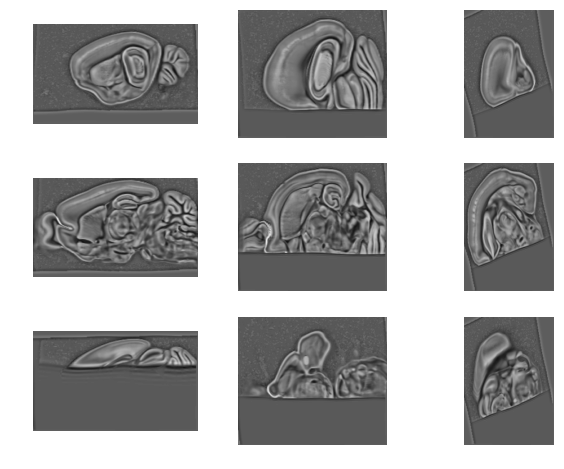

In [48]:
ndreg.imgShow(sitk.Normalize(atlas_lddmm))

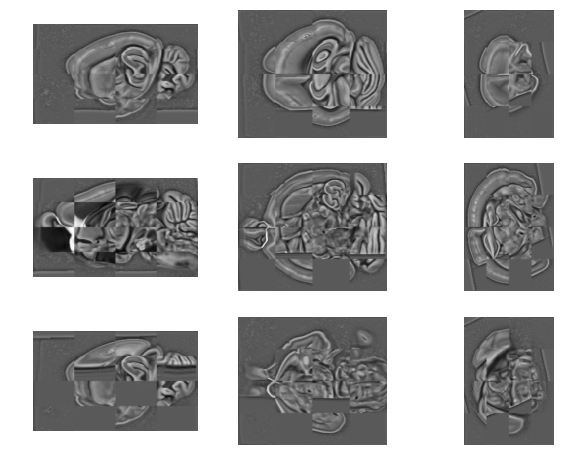

In [50]:
ndreg.imgShow(ndreg.imgChecker(sitk.Normalize(img_bc_ds_whitened), sitk.Normalize(atlas_lddmm)))
              

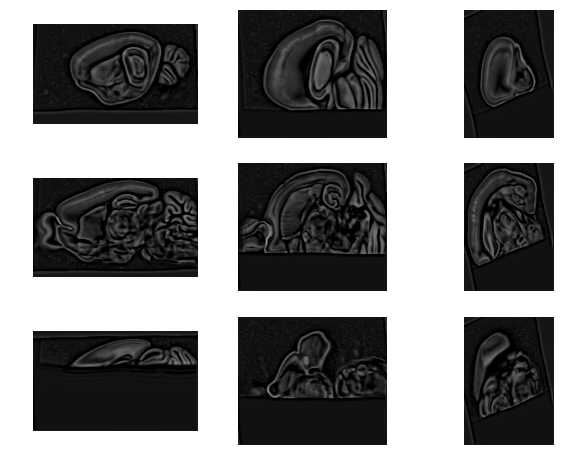

In [51]:
ndreg.imgShow(atlas_lddmm, vmax=10, vmin=-1)

# Ingest into BOSS

In [55]:
sitk.WriteImage(sitk.Normalize(atlas_lddmm), 'registered_results.img')

In [56]:
%ls

Insula ndreg missing data registration.ipynb  masked_atlases.png
Insula ndreg registration.ipynb               missing_data_reg.ipynb
Known missing data masks.ipynb                missing_data_reg_1.ipynb
Thy1eYFP ndreg Registration.ipynb             missing_data_sim.py
affine_plot.png                               missing_data_sim.pyc
annotated_img/                                ndreg/
archive/                                      plot.png
ingest_tif_stack.py                           registered_results.hdr
intern.cfg                                    registered_results.img


In [54]:
# channel_res = get_channel_resource(rmt, 'masked', 'missing_data_registration', 'whole_atlas_to_half_atlas_reg')
atlas_array = sitk.GetArrayFromImage(sitk.Normalize(atlas_lddmm))
atlas_array.dtype
# upload_to_boss(rmt, atlas_array, channel_res)

dtype('float64')

In [57]:
%run -i ingest_tif_stack.py -collection=missing_data_registration -experiment=whole_atlas_to_half_atlas_reg -channel=Ch0 -img_stack=./registered_results.img -fmt=img --dtype=float64 --config=./intern.cfg --new_channel=True

True
uploading image to boss...
uint16
(0, [0, 264], [0, 160], [0, 16])
(0, [0, 264], [0, 160], [16, 32])
(0, [0, 264], [0, 160], [32, 48])
(0, [0, 264], [0, 160], [48, 64])
(0, [0, 264], [0, 160], [64, 80])
(0, [0, 264], [0, 160], [80, 96])
(0, [0, 264], [0, 160], [96, 112])
(0, [0, 264], [0, 160], [112, 128])
(0, [0, 264], [0, 160], [128, 144])
(0, [0, 264], [0, 160], [144, 160])
(0, [0, 264], [0, 160], [160, 176])
(0, [0, 264], [0, 160], [176, 192])
(0, [0, 264], [0, 160], [192, 208])
(0, [0, 264], [0, 160], [208, 224])
(0, [0, 264], [0, 160], [224, 228])
upload done! to see upload go to this link: http://ben-dev.neurodata.io:8001/ndviz_url/missing_data_registration/whole_atlas_to_half_atlas_reg/Ch0/
